<h2>1. Preamble</h2>

In [1]:
import numpy as np
import pandas as pd
from datetime import date

In [12]:
#parameters

#training
batch_size = 30 
block_size = 90

#model
n_embed = 180 
n_heads = 6 
#head_size = n_embed//n_heads = 30

#optimisation
learn_rate = 7e-4
iterations = 1000

#deployment
predict_size = 60

<h2>2. Data</h2>

<h3>2.1 Download data (skip if downloaded)</h3>

In [148]:
#getting data from FRED

import requests 

today = date.today().isoformat()
startdate = '2014-04-14'#on or after 1982-01-04
enddate = today #on or before today
objId = 'T10Y3M'
#objId=SP500 between 2014-04-14 and today inclusive
filename = objId + '_' + startdate + '_' + enddate + '.csv'

url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?'
url += 'bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&'
url += 'graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&'
url += 'txtcolor=%23444444&ts=12&tts=12&width=1318&nt=0&thu=0&trc=0&'
url += 'show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=' + objId
url += '&scale=left&cosd=' + startdate + '&coed=' + enddate + '&line_color=%234572a7&'
url += 'link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&'
url += 'ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&'
url += 'fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&'
url += 'vintage_date='+ today + '&revision_date=' + today  + '&nd=1982-01-04'

r = requests.get(url, stream = True)
with open(filename,'wb') as f:
    for content in r.iter_content(chunk_size = 1024):
        if content:
            f.write(content)


<h3>2.2 Prepare data</h3>

In [3]:
#calculate the increments

#Suppose data is saved to 'T10Y3M_1998-10-30_2024-04-13.csv'
path  = 'T10Y3M_1998-10-30_2024-04-13.csv'
datCol = 'T10Y3M'
timeCol = 'DATE'

#convert data from string to float
def numeric_data(path):
    df = pd.read_csv(path)
    df = df.loc[df[datCol] != '.']

    df[datCol] = df[datCol].apply(lambda x: round(float(x),2))
    return df

#find (logarithmic) increments
def increment_arr(df,log_incr=False):
    
    df_len = df.shape[0]
    df_num = pd.DataFrame(np.array(df[datCol]))
    
    if log_incr:
        ar1 = np.log(np.array(df_num.drop(0)))
        ar2 = np.log(np.array(df_num.drop(df_len - 1)))
    else:
        ar1 = np.array(df_num.drop(0))
        ar2 = np.array(df_num.drop(df_len - 1))
    
    incr1 = pd.Series((ar1 - ar2).flatten())
    incr1 = incr1.rename(datCol)
    
    return incr1

df = numeric_data(path)
incr1 = increment_arr(df,False)





<h2>3. Building models</h2>

<h3>3.1 Import Pytorch and convert increment vector to torch tensor</h3>

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as Func

#set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'



<h3>3.2 Training infrastructure (tokens and batches making)</h3>

In [5]:
#tokeniser
rounding = 2
'''
the following tokeniser is optimised for T10Y3M, 
where the increments are expected to vary 
by steps of size which are multiples of 0.01
and the maximum increment is 1.00 in magnitude.
'''

def tokenise(a):
	a = round(a,rounding)
	if a >= 0:
		return int(2*a*(10**rounding))
	if a < 0:
		return int(-a*2*(10**rounding) - 1)

def detokenise(a):
	if a%2:
		return -(a + 1)/(2*(10**rounding))
	if (not a%2):
		return a/(2*(10**rounding))

#mapping the tokensier over python lists

def encode(a):
	return list(map(tokenise,list(a)))

def decode(a):
	return list(map(detokenise,list(a)))

#encode increment vector
incr_enc = encode(incr1)



In [6]:
#convert encoded increment vector to torch tensor
data = torch.tensor(incr_enc,dtype = torch.long)

#find necessary size of dimension for 1-hot/other encoding
vocabsize = max(max(incr_enc),200)

n_split = int(0.8*len(data))
train_data = data[:n_split]
val_data = data[n_split:]

#batch-making function
def batchify(split):
    batch_data = train_data if split == 'train' else val_data
    #torch.randint(max, size)
    ix = torch.randint(len(batch_data) - block_size, (batch_size,))
    x = torch.stack([batch_data[i:i + block_size] for i in ix])
    y = torch.stack([batch_data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

<h3>3.3 Bi-gram network</h3>

In [15]:
#a bigram model
class BigramLanguageModel(nn.Module):

    #initialisation and inheritance from nn.Model
    def __init__(self, vocabsize):
        super().__init__()
        #initiate an embedding table class
        self.token_embedding_table = nn.Embedding(vocabsize,vocabsize)

    #one layer forward
    def forward(self, idx, targets= None):
        #idx is a tensor of B (batch_size) vectors 
        #    of T (block_size) encoded increments
        #logits is the expanded tensor where each 
        #    encoded increment is replaced by a vector
        #    of length C (n_embed (which is vocabsize 
        #    here)acquired from the embedding table 
        logits = self.token_embedding_table(idx)
        #print(logits.shape)
        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            #logits and targets have to 
            #   be re-arranged to feed into 
            #   Func.cross_entropy
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = Func.cross_entropy(logits,targets)
        return logits, loss

    #generation loop
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self.forward(idx,None)
            #we only want the previous step 
            logits = logits[:,-1,:]
            #normalise to calculate probability vector
            probs = Func.softmax(logits, dim= -1)
            #calculate next based on multinomial distribution 
            #    using the calculated probability vector
            idx_next = torch.multinomial(probs, num_samples = 1)
            #concatenate to make a bigram 
            idx = torch.cat((idx, idx_next), dim = 1)
        return idx

<h3>3.4 Decoder attention network</h3>

<h4>3.4.1 Attention heads</h4>

In [7]:
#attention part of attention model
#    tokens speak with one another
#    only backward in 'time'

#attention head
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        #each token at each position 
        #    gets associated with three vectors:
        #    query: what am i looking for
        #    key: what do i contain
        #    value: what i can transmit 
        #    if query and key are aligned, 
        #    their inner product is large
        #    output is value weighted by query dot key
        self.key   = nn.Linear(n_embed, head_size, bias = False)
        self.query = nn.Linear(n_embed, head_size, bias = False)
        self.value = nn.Linear(n_embed, head_size, bias = False)
        self.head_size = head_size
        #self.dropout = nn.Dropout(0.3)
        #a lower triangular masking matrix:
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    
    #one head step
    def forward(self, x):
        #B: batch_size
        #T: block_size
        #C: channel size (n_embed (which vocabsize is 
        #                transformed into via the 
        #                token_embedding_table in the 
        #                AttentionModel class))
        B,T,C = x.shape
        k = self.key(x) #(B,T,head_size)
        q = self.query(x) #(B,T,head_size)
        v = self.value(x) #(B,T,head_size)
        #transpose for matrix product 
        #    k.transpose(-2,-1) #(B,head_size,T)
        #    transpose the final two dimensions, -2 and -1 
        #normalisation with 1/sqrt(head_size)
        #weights encode attention scores/"affinities"
        weights = q @ k.transpose(-2, -1) * (self.head_size**(-0.5)) #(B, T, T)
        #masking: where tril is 0, fill in float('-inf') for weights
        #    gives an arrow of time --- 'decoder block'
        #    no masking for 'encoder blocks' for sentiment analysis
        weights = weights.masked_fill(self.tril==0, float('-inf'))
        #implement dropout here
        #weights = self.dropout(weights)
        #take the softmax (exponentiate and normalise)
        weights = Func.softmax(weights, dim =1)
        return weights @ v #(B,T,head_size)

#multi-head attention
class MultiHead(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        #list of Head modules which run separately
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        #projection layer to permit addition to residual pathway output
        self.proj = nn.Linear(head_size*n_heads, n_embed)
        #throw in dropout layer 2
        #self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        #concatentate heads in channel dimension
        out = torch.cat([h.forward(x) for h in self.heads], dim = -1)
        #h.forward(x) has dimensions (B, T, head_size)
        #    concatenated --> out.shape = (B,T, head_size*n_heads)
        #projection back onto residual pathway
        #return self.dropout(self.proj(out)) #(B,T,n_embed)
        return self.proj(out)


<h4>3.4.2 Feed forward/neural net layer</h4>

In [8]:
#feed forward layer
#'neural net' part of attention model
#    each individual token
#    reflects on communication
#    which occurred in the attention layers

class FeedForward(nn.Module):
    
    def __init__(self, n_embed):
        super().__init__()
        self.pertoken = nn.Sequential(
            nn.Linear(n_embed, 4* n_embed),
            nn.ReLU(),
            nn.Dropout(0.3),
            #projection back onto residual pathway
            nn.Linear( 4*n_embed, n_embed),
        )

    def forward(self, x):
        return self.pertoken(x)

<h4>3.4.3 Assemble heads and feed-forward layers into a block</h4>

In [9]:
#put attention and feed-forward steps together in a block

class Block(nn.Module):
    
    def __init__(self, n_embed, n_heads):
        super().__init__()
        head_size = n_embed// n_heads #recall a//b = floor(a/b)
        # when there is only one attention head
        #    head_size = n_embed
        self.selfAtt_heads = MultiHead(n_heads, head_size)
        self.feedFwd = FeedForward(n_embed)
        self.lnorm1 = nn.LayerNorm(n_embed)
        self.lnorm2 = nn.LayerNorm(n_embed)
    
    #group communication (attention) and 
    #computation (feed forward/neural net)
    #into one block step forward
    def forward(self, x):
        #residual path 'x +', i.e., explicit euler:
        # x = x + self.selfAtt_heads.forward(self.lnorm1(x))
        # x = x + self.feedFwd.forward(self.lnorm2(x))
        #2nd order runge--kutta:
        y1 = x + 0.5*self.selfAtt_heads.forward(self.lnorm1(x))
        y2 = x + 0.5*self.feedFwd.forward(self.lnorm2(x))
        x = x + self.selfAtt_heads.forward(self.lnorm1(y1))
        x = x + self.feedFwd.forward(self.lnorm2(y2))
        return x
    

<h4>3.4.4 Assemble the entire model</h4>

In [10]:
#GPT type model

#assembled model
class AttentionModel(nn.Module):
    
    def __init__(self, vocabsize, n_embed, n_heads):
        super().__init__()
        #embed identity of token
        self.token_embedding_table = nn.Embedding(vocabsize, n_embed)
        #embed position of token
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        #self.selfAtt_head = Head(n_embed)
        #self.selfAtt_heads = MultiHead(n_heads, n_embed//n_heads)
        self.Blocks = nn.Sequential(
            Block(n_embed, n_heads),
            Block(n_embed, n_heads),
            Block(n_embed, n_heads),
            nn.LayerNorm(n_embed),
        )
        self.lm_head = nn.Linear(n_embed, vocabsize)

    #one block of layers forward
    def forward(self, idx, targets):
        tok_embed = self.token_embedding_table(idx) #(B,T,n_embed)
        pos_embed = self.position_embedding_table(torch.arange(block_size,device = device)) #(B,T,embed)
        x = tok_embed + pos_embed #(B,T,n_embed)
        x = self.Blocks(x)
        logits = self.lm_head(x) #(B,T,vocabsize)
        if targets == None:
            loss = None
        else:
            B, T, C2 = logits.shape
            #logits and targets have to 
            #   be re-arranged to feed into 
            #   Func.cross_entropy
            logits = logits.view(B*T, C2)
            targets = targets.view(B*T)
            loss = Func.cross_entropy(logits,targets)
        return logits, loss
    
    #generation loop
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            #only take up to block size from idx
            idx_blk = idx[:, - block_size:]
            logits, loss = self.forward(idx_blk,None)
            #we only want the previous step (it's Markov!)
            logits = logits[:,-1,:]
            #normalise to calculate probability vector
            probs = Func.softmax(logits, dim= -1)
            #calculate next based on multinomial distribution 
            #    using the calculated probability vector
            idx_next = torch.multinomial(probs, num_samples = 1)
            #concatenate to make a bigram 
            idx = torch.cat((idx, idx_next), dim = 1)
        return idx


<h2>4. Training loop</h2>

In [13]:
#initiate model
#m = BigramLanguageModel(vocabsize).to(device)
m = AttentionModel(vocabsize,n_embed,n_heads).to(device)

#optimiser using ADAM optimisation
optimiser = torch.optim.Adam(m.parameters(), lr = learn_rate)

#validation loop
#does not need to keep track of grad for back propagation
@torch.no_grad()
def eval_iterator():
    xv, yv = batchify('val')
    return m.forward(xv,yv)

#training loop
def train_iterator(iterations):
    out = []
    m.eval()
    for step in range(iterations):
        #sample a batch
        xt, yt = batchify('train')
        #find the loss, train and back propagate
        logits, loss = m.forward(xt,yt)
        optimiser.zero_grad(set_to_none=True)
        loss.backward()
        optimiser.step()
        #every 20 training iterations, 
        #    record training loss, 
        #    run validation, 
        #    record validation loss
        if step%20 == 1:
            A = [loss.item()]
            _, loss = eval_iterator()
            A.append(loss.item())
            print(f"step {step}: training loss = {A[0]:.4f}, validation loss = {A[1]:.4f}")
            out.append(A)
    m.train()
    return out


In [14]:
out = train_iterator(1000)

step 1: training loss = 5.0442, validation loss = 4.6460
step 21: training loss = 3.1868, validation loss = 3.3390
step 41: training loss = 3.2928, validation loss = 3.2606
step 61: training loss = 3.1716, validation loss = 3.1506
step 81: training loss = 3.1446, validation loss = 3.2330
step 101: training loss = 3.1869, validation loss = 3.2313
step 121: training loss = 3.1482, validation loss = 3.2441
step 141: training loss = 3.0467, validation loss = 3.2329
step 161: training loss = 2.7525, validation loss = 2.8183
step 181: training loss = 2.2041, validation loss = 2.4911
step 201: training loss = 1.5764, validation loss = 1.6553
step 221: training loss = 0.9212, validation loss = 1.2557
step 241: training loss = 0.6863, validation loss = 1.0440
step 261: training loss = 0.4011, validation loss = 0.7146
step 281: training loss = 0.3518, validation loss = 0.4044
step 301: training loss = 0.2464, validation loss = 0.4075
step 321: training loss = 0.1553, validation loss = 0.4368
ste

<h2>5. Generation</h2>

In [41]:
#generate new increments

#out2 = train_iterator(22)

predict_size = 60
#start with final context window size bit of time series:
context = data[-block_size:].view(1,block_size)
#context = torch.zeros((1,64), dtype = torch.long, device = device)
prediction = decode(m.generate(context, max_new_tokens = predict_size)[0].tolist())
print(prediction)

[0.03, -0.09, -0.06, 0.03, 0.09, -0.03, -0.02, -0.14, -0.11, -0.02, 0.02, 0.01, -0.08, 0.05, -0.01, -0.02, -0.09, 0.04, 0.09, 0.01, -0.06, 0.08, 0.07, -0.06, 0.03, 0.03, -0.06, -0.01, 0.11, 0.01, 0.06, 0.01, -0.05, 0.04, 0.05, -0.04, 0.01, -0.05, -0.02, -0.07, -0.12, 0.15, 0.15, -0.1, 0.01, 0.05, 0.02, 0.01, 0.12, -0.02, -0.03, 0.05, -0.03, 0.05, 0.0, -0.08, 0.01, 0.05, -0.04, -0.02, -0.03, -0.03, -0.08, -0.02, -0.02, 0.01, -0.01, 0.06, 0.03, 0.1, 0.02, 0.03, -0.04, -0.02, -0.01, -0.03, 0.03, -0.01, -0.03, -0.01, 0.15, 0.05, 0.0, -0.04, 0.06, 0.03, -0.06, 0.17, 0.01, -0.06, 0.03, 0.0, -0.01, -0.06, 0.03, 0.05, 0.03, -0.02, 0.08, 0.0, 0.05, -0.05, -0.02, -0.12, 0.1, -0.06, 0.01, -0.07, 0.03, -0.05, 0.03, 0.05, 0.02, 0.01, 0.01, 0.05, -0.01, 0.0, 0.06, -0.01, 0.19, -0.07, -0.05, 0.02, -0.15, -0.07, -0.1, -0.03, -0.06, -0.01, -0.04, 0.09, -0.01, -0.07, -0.05, -0.04, 0.03, 0.09, -0.02, 0.05, 0.02, -0.03, -0.02, 0.01, 0.02, -0.12, 0.06, -0.09, 0.03, -0.09]


In [47]:
#sum up the increments in the prediction vector
#    starting with value of df at -block_size -1:

sum_pred = [df.iloc[-block_size - 1][1]]

for idx, inc in enumerate(prediction):
    # addin = sum_pred[idx] + inc
    sum_pred.append(sum_pred[idx] + inc)

sum_pred = sum_pred[1:]

#sum_pred2 attenuates sum_pred, 
#    if the increment is too wild,
#    it moderates the increment
#    in a very crude way
sum_pred2 = [df.iloc[-block_size - 1][1]]

for idx, inc in enumerate(prediction):
    # addin = sum_pred[idx] + inc
    if abs(inc) <= 0.2:
        sum_pred2.append(sum_pred2[idx] + inc)
    else:
        sum_pred2.append(sum_pred2[idx] + float(np.sign(inc))*0.12 )
    addin = inc

sum_pred2 = sum_pred2[1:]

In [48]:
#import new data 
path2 = 'T10Y3M_2014-04-14_2024-06-15.csv'
#datCol = 'T10Y3M'
df2 = pd.read_csv(path2)
df2 = df2.loc[df2[datCol] != '.']
df2[datCol] = df2[datCol].apply(lambda x: float(x))

#print(df2.head())

#find starting index of comparison:
comp_startdate = date.fromisoformat(df['DATE'].iloc[-block_size])
df2['DATE'] = df2['DATE'].apply(lambda x : date.fromisoformat(x))
df_num2 = df2.loc[df2['DATE']>= comp_startdate]

#prediction window = min of df2 length and pre-set prediction size
comp_len = min(df_num2.shape[0],block_size + predict_size)
df_num2 = df_num2[:comp_len]

print(df_num2.head())



<function matplotlib.pyplot.show(close=None, block=None)>

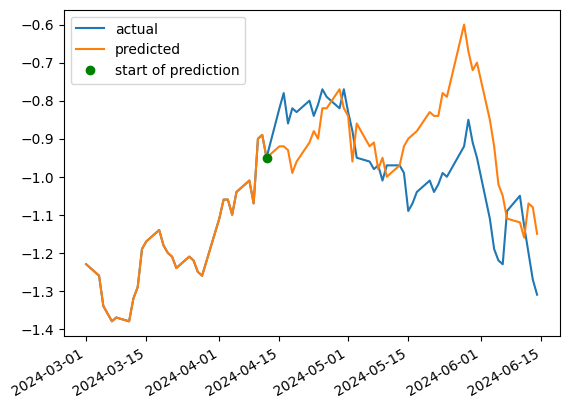

In [51]:
#plot predictions
import matplotlib.pyplot as plt

sum_pred_t = sum_pred[:comp_len]
sum_pred_t2 = sum_pred2[:comp_len]
#offset so initial block does not need 
#    to be shown
offset = 2*(block_size//3)

plt.plot(df_num2['DATE'][offset:],df_num2['T10Y3M'][offset:], label='actual')
plt.gcf().autofmt_xdate()
plt.plot(df_num2['DATE'][offset:],sum_pred_t2[offset:], label='predicted')
plt.plot(df_num2['DATE'].iloc[block_size - 1],df_num2['T10Y3M'].iloc[block_size - 1], 'o', color='green', label='start of prediction')
plt.legend(loc = 'upper left')
plt.show